# AllLife Bank Customers Segmentation

In this notebook, two clustering techniques have been applied to identify different segments or clusters in which to place existing customers of AllLife Bank based on their past interactions with the Bank and their spending patterns. **Exploratory Data Analysis** is also carried out on the given dataset in order to provide insights to the Bank's management on how to better market their services to these customers. 


# Given Data Dictionary 

### Customer details:

* Sl_No: Primary key of the records
* Customer Key: Customer identification number
* Average Credit Limit: Average credit limit of each customer for all credit cards
* Total credit cards: Total number of credit cards possessed by the customer
* Total visits bank: Total number of Visits that customer made (yearly) personally to the bank
* Total visits online: Total number of visits or online logins made by the customer (yearly)
* Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)


## Problem Definition:

> - To apply different clustering techniques to figure out an appropriate number of clusters or segments to place the bank's customers. 
> - To profile the customers in each of the clusters and then list the insights about the different clusters.
> - To apply Exploratory Data Analysis on the existing customer data and provide other insights and recommendations to the business.

<p>We'll start off by importing the necessary python libraries</p>

# 1. Import the Libraries

In [1]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist  #Pairwise distribution between data points
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.cluster import AgglomerativeClustering 

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# 2. Quick Overview of data.

Read the "Credit Card Customer Data.xlsx" dataset supplied for the project and explore it. Specifically, we will

- Import the xlsx file from disk into a pandas dataframe which we'll call **df**.
- Create a back up fresh copy of the dataframe which we'll call **df1**
- See the number of rows and columns it contains (the shape) and column types.
- Check any random 10 rows to have a feel of the data.
- Check for duplicates in the dataset and merge.
- Identify any missing values and prepare to treat them.

In [2]:
#loading the dataset
df = pd.read_excel("Credit Card Customer Data.xlsx")
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns.')  # Prints out the number of rows and columns

df1 = df.copy() # Let's create a back up copy before manipulating df.

# I'm now going to look at 10 random rows
# I'm setting the random seed via np.random.seed so that
# I get the same random results every time
np.random.seed(1)
df.sample(n=10)

There are 660 rows and 7 columns.


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
547,548,38125,26000,4,5,2,4
353,354,94437,9000,5,4,1,3
499,500,65825,68000,6,4,2,2
173,174,38410,9000,2,1,5,8
241,242,81878,10000,4,5,1,3
341,342,70779,18000,4,3,2,0
647,648,79953,183000,9,0,9,2
218,219,28208,19000,3,1,5,7
120,121,16577,10000,4,2,4,6
134,135,31256,13000,4,1,5,7


In [3]:
# Check for duplicates in the dataset
df[df.duplicated()].count() 

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

As observed above, there are no **DUPLICATE ROWS** to be merged. Let's go ahead and observe the column data types

In [4]:
#Basic info about the dataframe; count of non-null and column data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


There seem to be no missing values. Let's confirm that below with a count of missing values for each column

In [5]:
#Sum of missing values in each column
df.isna().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

Let's see the count of unique classes in each variable.

In [6]:
#Unique values count for each variable
df.nunique()

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

**Observations from Unique Count**

- The unique count gives us the idea of all the **truely** numerical variables and those numerical variables that are better treated as categorical variables during **Exploratory Data Analysis**. 
- We also observe that the **Sl_No** is completely unique for each row of data.
- We expected **Customer Key** to also be unique going by its title. Unfortunately there are a few duplicate **Customer Key** entries since we have 655 unique entries instead of 660. 

Lets have a closer look at the **Customer Key** entries. Let's keep the value counts in a series variable and retrieve the top 10 **Customer Key** values to see the possible duplicates.

In [7]:
# Value counts of each entry in Customer key
series = df['Customer Key'].value_counts()
series.nlargest(n=10)

50706    2
37252    2
97935    2
96929    2
47437    2
49331    1
72339    1
58511    1
20119    1
66200    1
Name: Customer Key, dtype: int64

The top 10 **Customer Key**s above shows that the following **Customer Keys** have been duplicated:
<pre> 
50706    2
37252    2
97935    2
96929    2
47437    2
</pre>

Although we've established earlier that the dataset doesn't have duplicates, it'll be interesting to see the values of other columns for these rows with same **Customer Keys** as follows:

In [8]:
# dataframe of rows with Customer Key of '50706'
df50706 = df[df['Customer Key'] == 50706]
df50706

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
411,412,50706,44000,4,5,0,2
541,542,50706,60000,7,5,2,2


In [9]:
# dataframe of rows with Customer Key of '37252'
df37252 = df[df['Customer Key'] == 37252]
df37252

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,49,37252,6000,4,0,2,8
432,433,37252,59000,6,2,1,2


In [10]:
# dataframe of rows with Customer Key of '97935'
df97935 = df[df['Customer Key'] == 97935]
df97935

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
104,105,97935,17000,2,1,2,10
632,633,97935,187000,7,1,7,0


In [11]:
# dataframe of rows with Customer Key of '96929'
df96929 = df[df['Customer Key'] == 96929]
df96929

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
391,392,96929,13000,4,5,0,0
398,399,96929,67000,6,2,2,2


In [12]:
# dataframe of rows with Customer Key of '47437'
df47437 = df[df['Customer Key'] == 47437]
df47437

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
4,5,47437,100000,6,0,12,3
332,333,47437,17000,7,3,1,0


None of the suspected duplicates are true duplicates as expected since our initial duplicate check returned zero duplicates. 

### Summary of Quick Overview of given data

Having completed step 2, we can deduce the following about the dataset supplied. 

- There are 660 rows of data with 7 variables (columns or features).
- All the 7 variables are all integers i.e. they are all numerical variables.
- The **Sl_No** variable by definition is **Primary Key of the records** and as expected, it is unique for each row in the dataframe. It won't add any value to the clustering model and therefore not an important feature and would be dropped. 
- Similar to the **Sl_No** variable, the **Customer Key** feature is expected to be unique for each customer but we have about 5 duplicates. This is a very small number compared to the entire 660 customers and could be a result of some database updates to existing customers. Therefore, we'll also drop the **Customer Key** column as it's not going to make much clustering impact to our model.
- We also conclude that there are no **duplicate** rows to merge.
- There are no variables with missing values. 
- Apart from the **Avg_Credit_Limit** variable, all the other 6 numerical variables have low unique value counts and can be treated as categorical variable during **Exploratory Data Analysis** in order to get insights from them. These **"numero-categorical"** variables areas follows:
  
<pre>
<strong>Variable              Unique Counts</strong>
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
</pre>

Let's combine these "somewhat" categorical variables and observe the count of each class within each variable as follows:

In [13]:
#Define an array of all the variables with small unique value counts
cat_cols=['Total_Credit_Cards','Total_visits_bank','Total_visits_online','Total_calls_made']

for column in cat_cols:
    print(df[column].value_counts())
    print('-'*30)

4     151
6     117
7     101
5      74
2      64
1      59
3      53
10     19
8      11
9      11
Name: Total_Credit_Cards, dtype: int64
------------------------------
2    158
1    112
0    100
3    100
5     98
4     92
Name: Total_visits_bank, dtype: int64
------------------------------
2     189
0     144
1     109
4      69
5      54
3      44
15     10
7       7
8       6
10      6
12      6
11      5
13      5
9       4
6       1
14      1
Name: Total_visits_online, dtype: int64
------------------------------
4     108
0      97
2      91
1      90
3      83
6      39
7      35
9      32
8      30
5      29
10     26
Name: Total_calls_made, dtype: int64
------------------------------


So far, so good, every unique element count looks okay, nothing unusual. We'll explore further after cleaning data.

# 3. Data Cleaning

Before we explore the data for Statistical Analysis, we need to clean it up. Specifically, we will:

- Drop the **Sl_No** column and the **Customer Key**

Then we'll check the statistical summary of the dataset

As stated already, the **Sl_No** variable is just a unique identifier for each customer and will not add value to  the model. The **Customer Key**, even though is expected to be unique, is unfortunately not unique entirely. But the fraction of duplicated items is so small that retaining **Customer Key** variable will not add much to our clustering Therefore, we'll drop it as well. So we'll drop both **Sl_No** column and the **Customer Key** column as follows:

In [14]:
#Dropping the Sl_No and Customer Key columns
df.drop(['Sl_No', 'Customer Key'], axis=1, inplace=True) 

In [15]:
df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


We can now check basic statistical summary of the dataset as follows:

In [16]:
#Basic statistical description of dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


### Basic Statistical Summary

- The average of the **Avg_Credit_Limit** is \\$34,574. The maximum Avg_Credit_Limit is \\$200,000 which is quite high compared with the median of \\$18,000. We expect Avg_Credit_Limit to be skewed.
- **Total_Credit_Cards** ranges from 1 to 10 with mean of 4.7 and median of 5. This seem to be evenly distributed.
- The average **Total_visits_bank** is 2.4 and it ranges from 0 to 5. 
- Most customers seem to have 4 credit cards the most with 151 of the 660 owning 4 credit cards. This is followed by 171 customers that own 6 credit cards. 
- 158 customers have visited the bank only **twice** which is the maximum number of customers count regarding bank visits. This is followed by 112 customers that have visited the bank only **once**. The lesser number of visits by most of the customers suggests that most of the customers prefer other channels to interact with the bank rather than frequent visits to the bank. They probably prefer online visits and phone calls.

Further analysis will reveal all the skewed variables and outliers. 

# 4. Exploratory Data Analysis on Entire Dataset

Let's do a quick exploratory Data Analysis on the given dataset. 


## 4.1 Univariate Analysis - Numerical Variables

Let's define a function to give boxplot and histogram for numerical variables.

In [17]:
# function to plot a boxplot and a histogram along the same scale.
def histogram_boxplot(data, feature, figsize=(6, 6), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="red"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

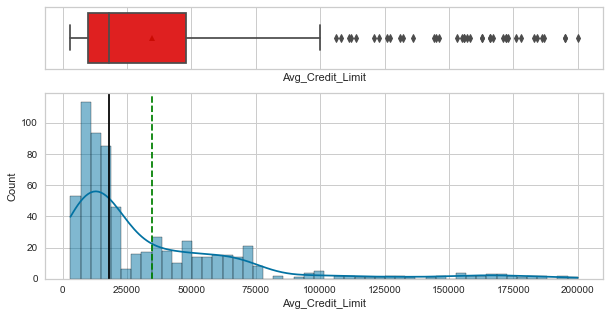

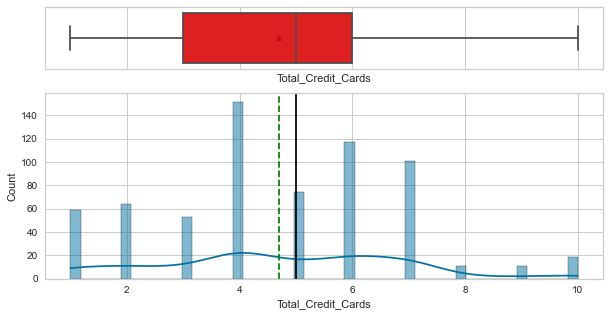

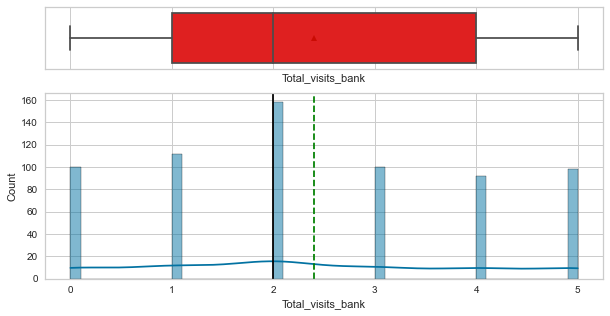

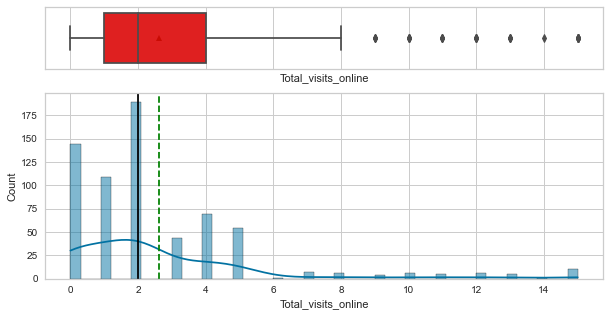

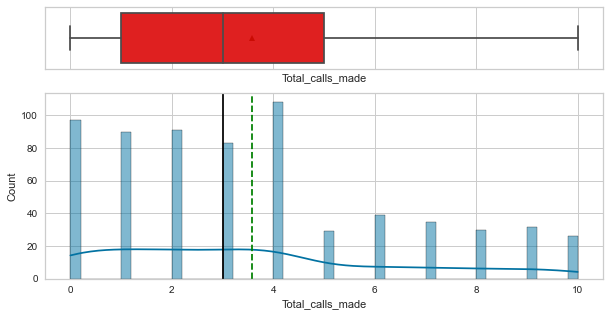

In [18]:
# selecting numerical columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()

for item in num_cols:
    histogram_boxplot(df, item, bins=50, kde=True, figsize=(10, 5))

 ### Summary of Univariate Analysis of Numerical Variables

- **Avg_Credit_Limit** is skewed to the right with some outliers.
- The outliers in **Avg_Credit_Limit** are not unexpected as there usually exist a wide range of allowable credit with most customers at the lower end of the limit. 
- Most of the other features are better treated like categorical variables even though it is observed that **total_visits_bank** and **total_credit_cards** appear fairly normally distributed. 
- **Total_calls_made** and **Total_visits_online** are both rightly skewed.
- While **Total_calls_made** doesn't have outliers, **Total_visits_online** have some outliers at the upper end. 

## 4.2 Univariate Analysis - Categorical Variables
Here, I've defined a function to create a labelled bar plot to visualize the value counts in percentage of the numerical categorical variables.

In [19]:
# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

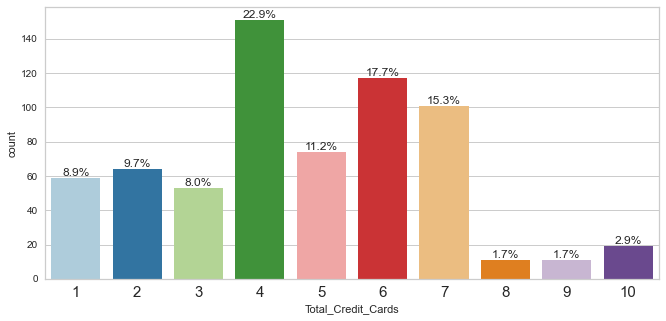

In [20]:
labeled_barplot(df1, "Total_Credit_Cards", perc=True)

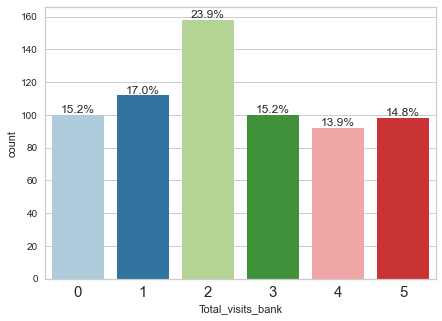

In [21]:
labeled_barplot(df1, "Total_visits_bank", perc=True)

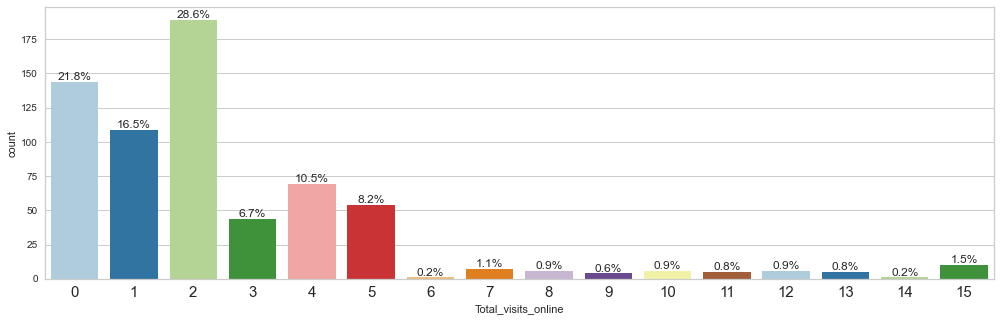

In [22]:
labeled_barplot(df1, "Total_visits_online", perc=True)

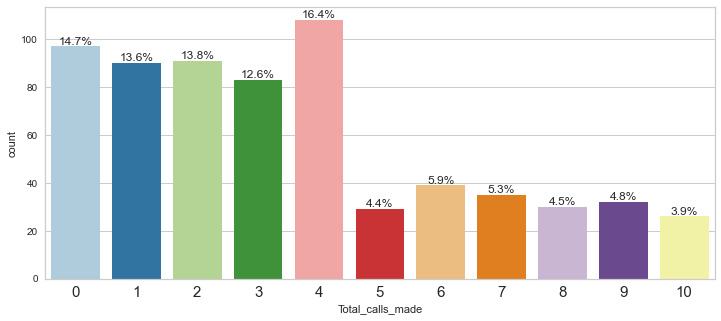

In [23]:
labeled_barplot(df1, "Total_calls_made", perc=True)

### Summary of Univariate Analysis of Categorical Variables

- The above plots show in percentage what we've already seen in value count numbers. 
- Each categorical plot exposes the dorminant way of customer interaction with the bank.
- For example, about 23% of customers have 4 credit cards, followed by 17.7% of customers having 6 credit cards.
- 16.4% of all customers contacted the bank by a total of 4 phone calls. This is followed by 14.7% of customers that made no calls at all. 
- Majority of the customers have fewer visits to the bank; the total percentage of combined count of customers that have zero, one and two visits to the bank is about 66% of all customers. The remaining 34% have visted the bank thrice, four or 5 times.
- The label plot of total calls made buttresses the above point that there are lesser visitors to the bank. A higher percentage of customers have made lesser calls (between 0 to 4 calls) to the bank; while a much smaller percentage of customers have made more calls (between 5 to 10 calls to the bank. 

## 4.3 Bivariate Analysis - Numerical Variables

Let's have a look at the Correlation and Heatmap plots of the core numerical variables.

In [24]:
df.corr()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Avg_Credit_Limit,1.000000,0.608860,-0.100312,0.551385,-0.414352
Total_Credit_Cards,0.608860,1.000000,0.315796,0.167758,-0.651251
Total_visits_bank,-0.100312,0.315796,1.000000,-0.551861,-0.506016
Total_visits_online,0.551385,0.167758,-0.551861,1.000000,0.127299
Total_calls_made,-0.414352,-0.651251,-0.506016,0.127299,1.000000


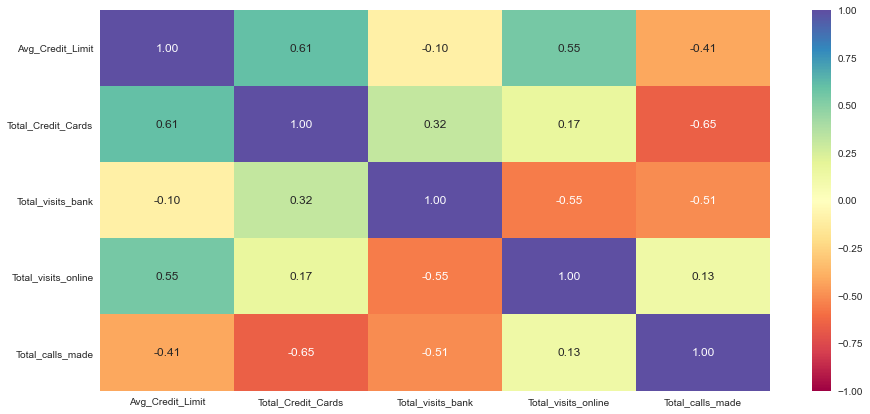

In [25]:
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(), annot=True,vmin=-1,vmax=1,fmt='.2f',cmap='Spectral')
plt.show()

**Observations**

- **Total_Credit_Cards** is correlated with **Avg_Credit_Limit**. This is obvious as more cards a customer gets is a commensurate increase in credit limits that adds up the limit on all the cards.
- **Total_visits_online** is also somewhat correlated with **Avg_Credit_Limit**. This could be a result of more spending as total_visits_online increases.
- **Total_visits_online** is negatively correlated to **Total_visits_bank**. This is not very surprising as frequent bank visitors means they prefer to visit bank than transact online and vice-versa. This is a clear case of customers that should be in different clusters/segments.
- **Total_calls_made** is also negatively correlated with **Total_Credit_Cards**.

Generally, the correlation has somewhat given us a hint of what is to be expected in the clusters that would be formed as we've observed certain variables that are positively correlated and those that are negatively correlated.

Let's have a look at the **pair plot** of these variables

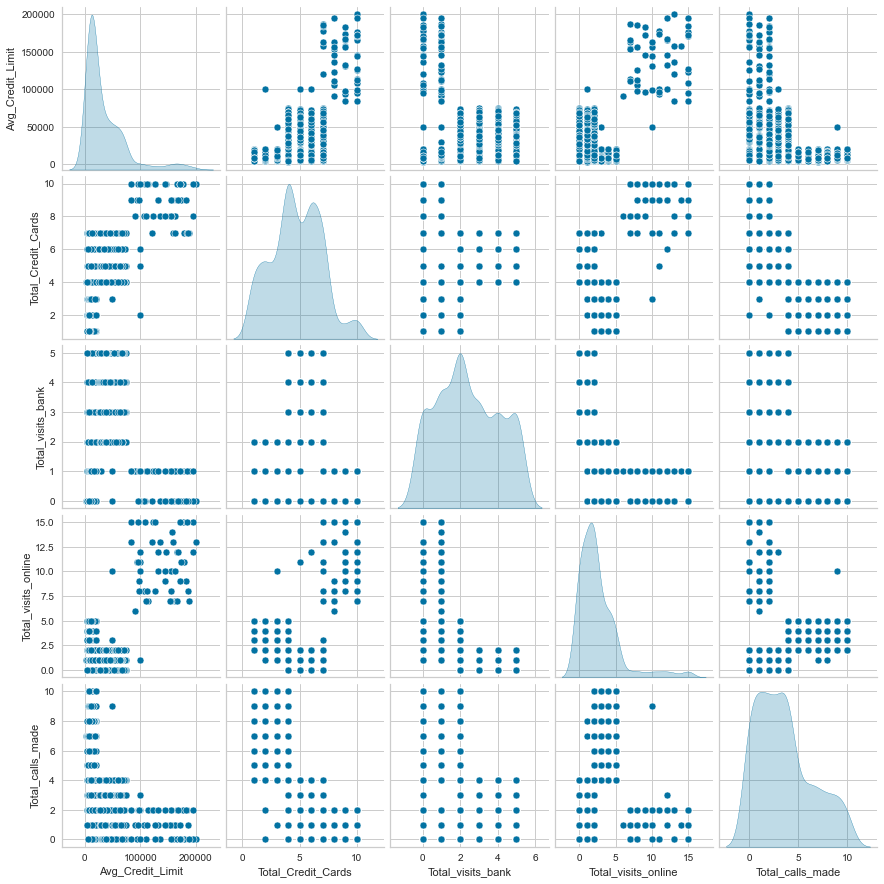

In [26]:
# selecting numerical columns
num_col = df.select_dtypes(include=np.number).columns.tolist()
sns.pairplot(data=df[num_col], diag_kind="kde")
plt.show()

**Observations**

- Most of the variables seems to be skewed to the right.
- Distribution of **Total_Credit_Card** and **Total_visit_bank** seem to have 4 modes.


# 5. Data Preparation for Modeling (Missing Values and Outliers)

- **Missing Values**: We have already observed that there are no missing values to treat in the dataset
- **Outliers**: We know that **Eucledian** distance metric is sensitive to outliers even if we scale the data. We also know that **Manhattan** distance metric (also known as **cityblock**) is less sensitive to outliers. 
- In this modelling problem, we'll be trying out all the most common distance metrics including manhattan (or cityblock).
- Therefore, we'll leave out treating outliers and see if the cityblock distance metric comes through with better clusters or not.

# 6. CLUSTERING

Now is the time to figure out the customer segments using two **CLUSTERING ALGORITHMS**

- K-Means Clustering
- Hierarchical Clustering


## 6.1 Applying K-Means Clustering

First, we'll try to figure out the appropriate number of clusters using these two different methods:
 
 - Elbow Method
 - Silhouette Score 

Then see the resulting clusters with the appropriate number of clusters, **k**. 
Before finding number of clusters, we'll need to scale the data to eliminate the effect of larger values.

In [27]:
# Scaling the data set before clustering
scaler = StandardScaler() #Declare the scaler to use
df_k = df.copy() #Let's create a copy of df for k-Means clustering, called df_k
scaled_k = scaler.fit_transform(df_k) #Next line performs scaling on df_k

In [28]:
# Creating a dataframe from the scaled data and displaying the dataframe
df_scaled_k = pd.DataFrame(scaled_k, columns=df_k.columns)
df_scaled_k.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


### 6.1.1 Elbow Method

In using K-Means, we do not know the number of clusters. In the evaluation that follows, we'll start with a range of values of clusters and try all the values in the range and plot the average distortions against the clusters range from the KMeans model.
K-Means clustering partitions the observations into the number of clusters so as to minimize the within-cluster sum of squares.

We'll try both **euclidean** and **cityblock** distance metrics

Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.990772333470802
Number of Clusters: 6 	Average Distortion: 0.9430843103448057
Number of Clusters: 7 	Average Distortion: 0.9094290022428964
Number of Clusters: 8 	Average Distortion: 0.8891380888508975


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

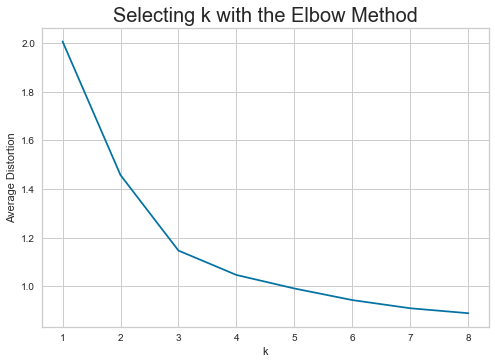

In [29]:
#We'll create a range of clusters to try in our quest to finding the appropriate number of clusters
clusters = range(1, 9)
#We'll keep the calculated average distortions in a list we'll name meanDistortions
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(df_scaled_k)
    prediction = model.predict(df_scaled_k)
    #Evaluate distortion using euclidean distance metric
    distortion = (
        sum(np.min(cdist(df_scaled_k, model.cluster_centers_, "euclidean"), axis=1))/ df_scaled_k.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

Number of Clusters: 1 	Average Distortion: 3.905283525283339
Number of Clusters: 2 	Average Distortion: 2.760368775999338
Number of Clusters: 3 	Average Distortion: 2.1844239785646864
Number of Clusters: 4 	Average Distortion: 2.0028758503430644
Number of Clusters: 5 	Average Distortion: 1.9147757822818394
Number of Clusters: 6 	Average Distortion: 1.8040889121679917
Number of Clusters: 7 	Average Distortion: 1.7392614887584215
Number of Clusters: 8 	Average Distortion: 1.703883975743915


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

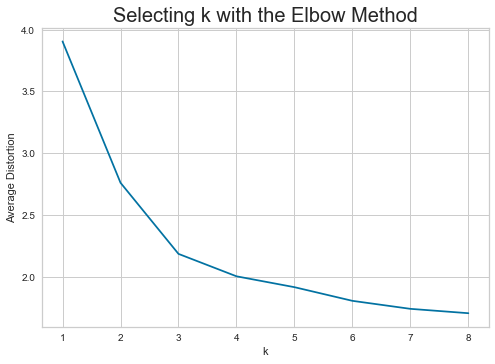

In [30]:
#We'll create a range of clusters to try in our quest to finding the appropriate number of clusters
clusters = range(1, 9)
#We'll keep the calculated average distortions in a list we'll name meanDistortions
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(df_scaled_k)
    prediction = model.predict(df_scaled_k)
    #Evaluate distortion using cityblock distance metric
    distortion = (
        sum(np.min(cdist(df_scaled_k, model.cluster_centers_, "cityblock"), axis=1))/ df_scaled_k.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

**Observation**
The appropriate value of k from the elbow curve seems to be 3 or 4 irrespective of metric distance used. Both elbow plots from either of **euclidean** or **cityblock** metric looks the quite similar.

Let's compare with the second method which is Silhouette Scores

### 6.1.2 Silhouette scores
We'll try out a range of clusters and calculate the silhouette score for each cluster. A value of 1 or close shows good clustering.

For n_clusters = 2, silhouette score is 0.41842496663215445
For n_clusters = 3, silhouette score is 0.5157182558881063
For n_clusters = 4, silhouette score is 0.3556670619372605
For n_clusters = 5, silhouette score is 0.2726898791817692
For n_clusters = 6, silhouette score is 0.2558123746389958
For n_clusters = 7, silhouette score is 0.24783809050391647
For n_clusters = 8, silhouette score is 0.2274490958459993


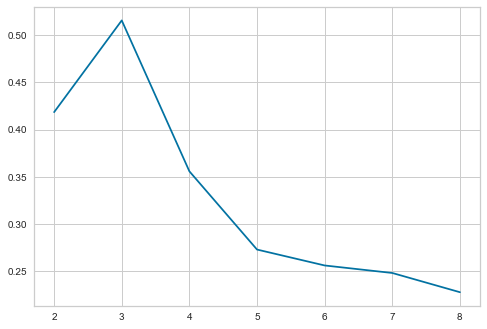

In [31]:
# WE define a list to hold all the scores for all the clusters we'll try
sil_score = []
cluster_list = list(range(2, 9)) # Range of clusters to evaluate their silhouette scores

for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    preds = clusterer.fit_predict((df_scaled_k))
    score = silhouette_score(df_scaled_k, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

We observe that 3 has the highest silhouette score. Let's visualize the silhouette plot for 3, 4 and 5; then see how well they fare for selecting a good cluster number

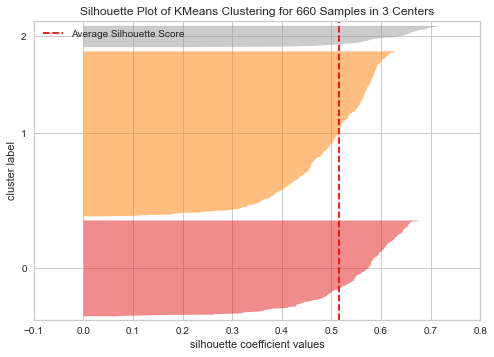

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [32]:
# finding optimal no. of clusters with silhouette coefficients using 3 clusters
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(df_scaled_k)
visualizer.show()

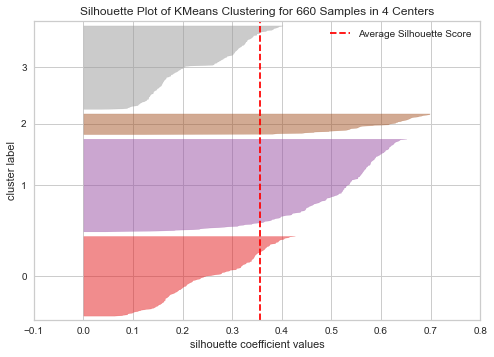

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [33]:
# finding optimal no. of clusters with silhouette coefficients using 4 clusters
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(df_scaled_k)
visualizer.show()

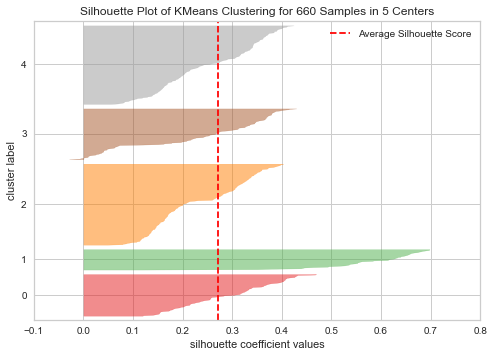

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [34]:
# finding optimal no. of clusters with silhouette coefficients using 5 clusters
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(df_scaled_k)
visualizer.show()

### Clusters count selection
The SilhouetteVisualizer seems to favour 4 clusters more than 3. Let's build a KMeans model with 4 clusters, create a cluster profile and observe if the clusters are distinct enough. If not, we can then revert to 3 clusters.

In [35]:
#KMeans cluster model with 4 clusters
kmeans4 = KMeans(n_clusters=4, random_state=0)
kmeans4.fit(df_scaled_k)

KMeans(n_clusters=4, random_state=0)

In [36]:
# adding kmeans cluster labels to the original dataframe
df_k["K_means_segments"] = kmeans4.labels_

### K-Means Cluster Profiling for 4 clusters

In [37]:
#define the cluster profile from the kmeans labels
k_means_cluster_profile4 = df_k.groupby("K_means_segments").mean()

In [38]:
k_means_cluster_profile4["Customers_in_each_segment"] = (
    df_k.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

In [39]:
# let's display cluster profiles followed by the box plot of the clusters
k_means_cluster_profile4.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Customers_in_each_segment
K_means_segments,,,,,,
0,31226.315789,5.478947,4.515789,1.010526,1.936842,190
1,12167.420814,2.393665,0.927602,3.574661,6.923077,221
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50
3,35904.522613,5.522613,2.477387,0.969849,2.075377,199


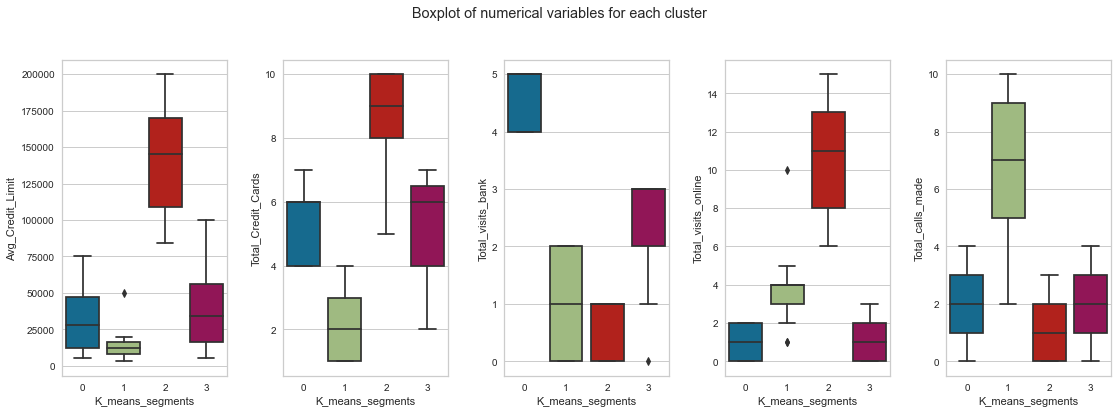

In [40]:
# Let's see the box plot for each cluster.
fig, axes = plt.subplots(1, 5, figsize=(16, 6))

fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df_k[num_col[counter]], x=df_k["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

**Observation of distinctness**

- A close look of these 4 clusters shows that Clusters 0 and 3 are quite similar both in the cluster profile table and in the box plot. 
- We may have split Cluster 0 and Cluster 3 in two clusters instead of having both as one cluster.
- The only column with significant difference in value is the **Total_visits_bank** column; this is obvious also in the box plot.
- All the other column values are quite close for Cluster 0 and Cluster 3, emphasizing their similarity.
- This suggests that we stick to 3 clusters instead of 4 clusters.

Let's repeat the above process with only 3 clusters instead of 4.

In [41]:
#KMeans cluster model with 3 clusters
kmeans3 = KMeans(n_clusters=3, random_state=0)
kmeans3.fit(df_scaled_k)

KMeans(n_clusters=3, random_state=0)

In [42]:
# adding kmeans cluster labels to the original dataframe
df_k3 = df.copy() 
df_k3["K_means_segments"] = kmeans3.labels_

In [43]:
#define the cluster profile from the kmeans labels
k_means_cluster_profile3 = df_k3.groupby("K_means_segments").mean()

In [44]:
k_means_cluster_profile3["Customers_in_each_segment"] = (
    df_k3.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

In [45]:
# let's display cluster profiles
k_means_cluster_profile3.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Customers_in_each_segment
K_means_segments,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


The above 3 clusters look distinct enough. There are no two clusters with comparably similar column values.
Let's also see the box plot for each cluster.

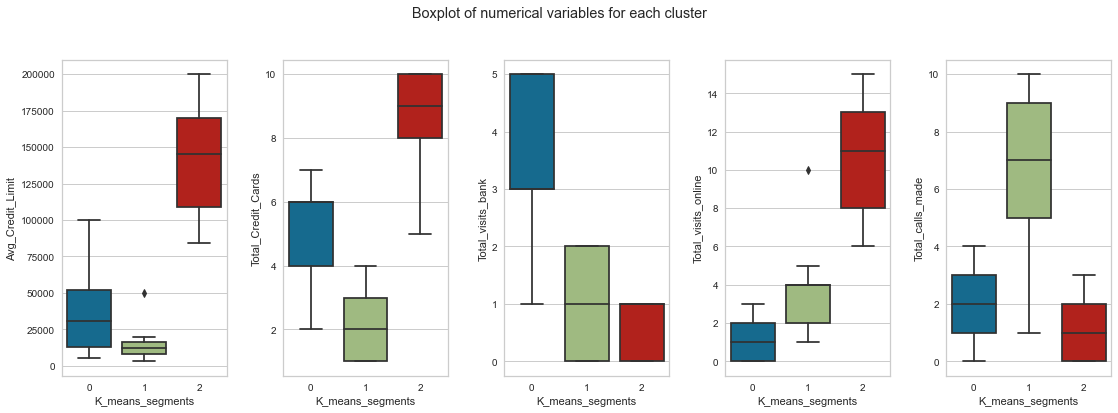

In [46]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))

fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df_k3[num_col[counter]], x=df_k3["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

**Observation**
The table of profile and the box plot confirms distinctness of using only 3 clusters.

Let's do a bar plot of all clusters.

<AxesSubplot:xlabel='K_means_segments'>

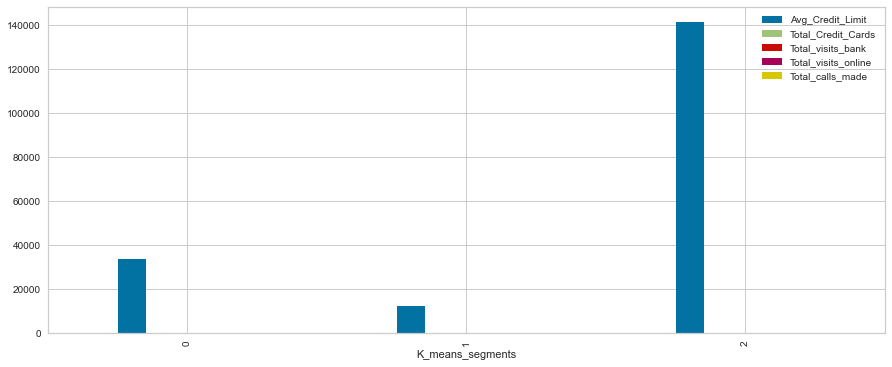

In [47]:
df_k3.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))

Unfortunately, since the variables are of different scales, the other variables of much lower scale than the Avg_Credit_Limit appear not to exist at all. Let's remove the **Avg_Credit_Limit** variable and visualize the other variables.

<AxesSubplot:xlabel='K_means_segments'>

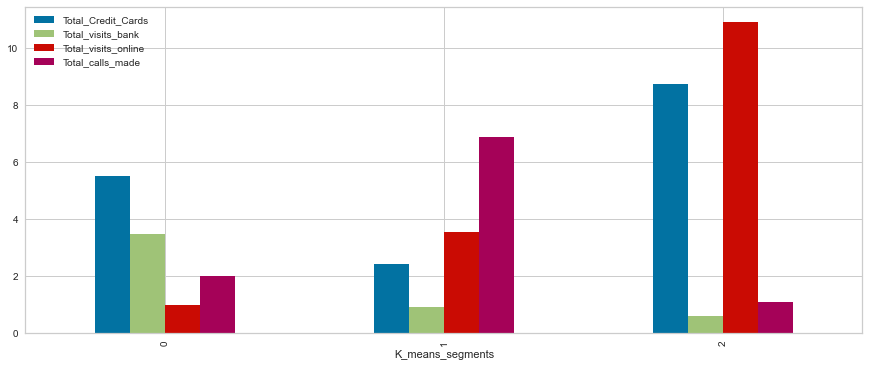

In [48]:
df_k3_NoAvgCreditLimit = df_k3.drop(columns="Avg_Credit_Limit")
df_k3_NoAvgCreditLimit.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))

The plots above lay bare before us the various clusters and their leanings towards each of the variables. 
We'll leave the insights from these plots towards the end after confirming the appropriate number of clusters from both KMeans and Hierarchical Clustering

Let's explore how Hierarchical Clustering technique will perform on same problem.

## 6.2 Applying Hierarchical Clustering

In the Hierarchical Clustering evaluation below, we have defined 4 distance metrics and 4 linkage methods to be used in order to find the combination of distance metric and linkage method that'll give us the highest cophenet index. cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram. A cophenet index that is closer to 1 gives a better clustering. 

**Centroid** and **ward** linkage methods use only euclidean distance, therefore they'll be treated separately.

In [49]:
# list of distance metrics to try
distance_metrics = [
    "euclidean",
    "chebyshev",
    "mahalanobis",
    "cityblock",
] 

# list of linkage methods used to calculate distance btw clusters
linkage_methods = [
    "single",
    "complete",
    "average",
    "weighted",
] 

high_cophenet_corr = 0
high_dm_lm = [0, 0]

#We loop through all possible combinations of distance metrics and linkage methods, evaluating the cophenetic 
#correlation for each combination, and retaining the combination with the highest cophenetic correlation
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(df_scaled_k, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(df_scaled_k))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553605.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6663534463875359.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042136.
Cophenetic co

In [50]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.


Euclidean distance with Average linkage has the highest cophenetic correlation of about **0.8977**. Let's evaluate cophenetic correlation using euclidean distance with each of centroid and ward linkage methods and observe if either will beat the current cophenetic correlation.

In [51]:
# list of distance metrics to try
distance_metrics = [
    "euclidean",
] 

# list of linkage methods used to calculate distance btw clusters
linkage_methods = [
    "centroid",
    "ward"
] 

high_cophenet_corr = 0
high_dm_lm = [0, 0]

#We loop through all possible combinations of distance metrics and linkage methods, evaluating the cophenetic 
#correlation for each combination, and retaining the combination with the highest cophenetic correlation
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(df_scaled_k, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(df_scaled_k))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and centroid linkage is 0.8939385846326323.
Cophenetic correlation for Euclidean distance and ward linkage is 0.7415156284827493.


The greater of the two correlations is not greater than the correlation gotten already with average linkage method. Therefore, we see that the cophenetic correlation is maximum with **Euclidean** distance and **Average** linkage.

Let's see the dendrograms for the different linkage methods with the following evaluation.

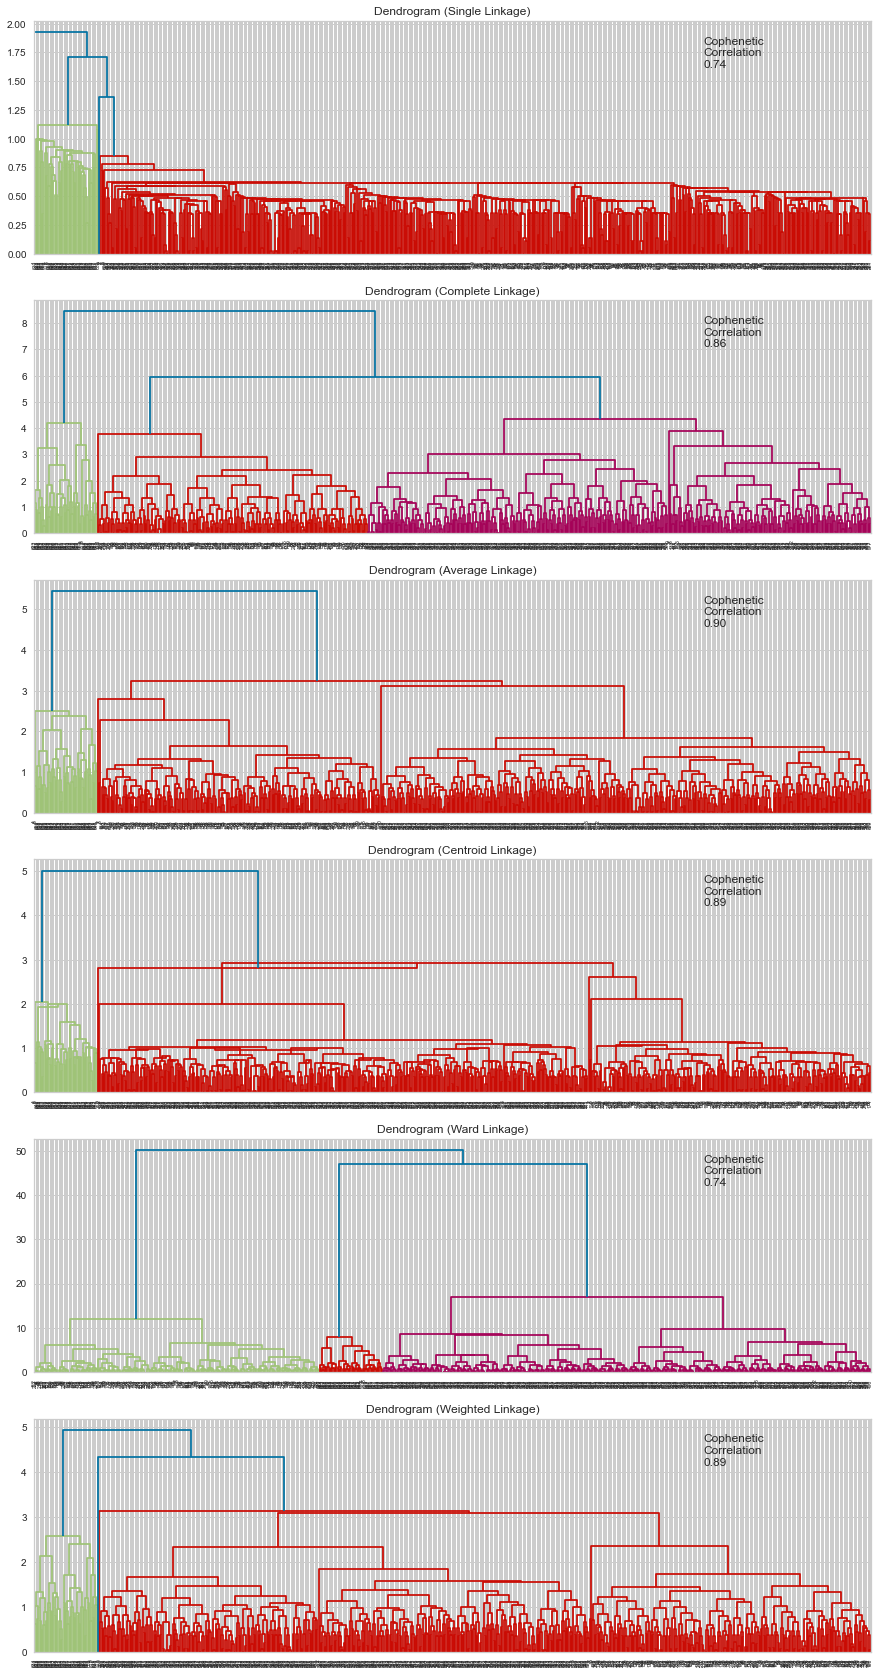

In [52]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(df_scaled_k, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(df_scaled_k))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

**Observations**

- **Average** linkage has the highest cophenetic correlation with a value of 0.9.
- The dendrogram for **average** linkage shows that it effectively has only 2 distinct clusters, separated by the two different colours in the dendrogram. The dendrogram also has low value of y-axis which reflects the distance between clusters. 
- Only two linkage methods have 3 distinct colours in the pack. 3 is the most number of distinct colours. 
- The linkage methods with up to 3 distinct colours are **complete** and **ward** linkage methods.
- We will try a model with 3 clusters using both complete and ward linkage and compare the clusters formed.
- **complete** and **ward** linkage methods are prefered to **average** that has only 2 distinct colours in the dendrogram and has low y-axis value (only 5)
- **Ward** has the largest y-axis value (up to 50) from the dendrogram. This should make it the most prefered linkage method. The cluster profiles will prove this assertion to be true.

We will start clustering model with **complete** linkage method with 3 clusters and then later with **ward** linkage method. HCmodel_Com will be the Hierarchical Clustering model using complete linkage.

In [53]:
#Hierarchical model using average linkage and 4 clusters
HCmodel_Com = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="complete")
HCmodel_Com.fit(df_scaled_k)

AgglomerativeClustering(linkage='complete', n_clusters=3)

In [54]:
#We get a copy of df to add the model labels for profiling.
df_HC_Com = df.copy()

In [55]:
df_HC_Com["HC_Com_Clusters"] = HCmodel_Com.labels_
df_HC_Com.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,HC_Com_Clusters
0,100000,2,1,1,0,0
1,50000,3,0,10,9,2
2,50000,7,1,3,4,0
3,30000,5,1,1,4,0
4,100000,6,0,12,3,1


### Cluster Profiling using 3 Clusters and Complete Linkage
Let's create the cluster profile 

In [56]:
HC_Com_cluster_profile = df_HC_Com.groupby("HC_Com_Clusters").mean()

In [57]:
HC_Com_cluster_profile["Customers_in_each_segment"] = (
    df_HC_Com.groupby("HC_Com_Clusters")["Avg_Credit_Limit"].count().values
)

In [58]:
# let's see the Avg_Credit_Limit of the customers in each cluster
for cl in df_HC_Com["HC_Com_Clusters"].unique():
    print("In cluster {}, the following Customers are present:".format(cl))
    print(df_HC_Com[df_HC_Com["HC_Com_Clusters"] == cl]["Avg_Credit_Limit"].unique())
    print()

In cluster 0, the following Customers are present:
[100000  50000  30000  15000   5000   7000   9000  12000  14000  20000
  11000  16000  10000   8000  17000  19000  13000  18000   6000  73000
  49000  67000  61000  75000  48000  56000  72000  70000  51000  69000
  40000  44000  31000  37000  65000  46000  74000  58000  39000  52000
  33000  47000  71000  41000  59000  64000  45000  54000  66000  27000
  43000  36000  25000  57000  26000  38000  35000  34000  28000  63000
  29000  68000  42000  62000  32000  60000  55000]

In cluster 2, the following Customers are present:
[50000 20000  3000 10000 13000 11000  9000  6000  8000 15000 19000  5000
 16000 18000 17000 14000 12000  7000]

In cluster 1, the following Customers are present:
[100000 157000  94000 163000 131000  96000 136000 121000 158000 108000
 166000 176000 178000  91000 156000 146000  84000 155000 200000 195000
 187000 106000 114000 126000 173000 153000 184000 123000 144000  97000
  98000 127000 171000 186000 183000 111000 1

In [59]:
# lets display cluster profile
HC_Com_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Customers_in_each_segment
HC_Com_Clusters,,,,,,
0,33151.133501,5.460957,3.405542,1.010076,2.060453,397
1,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,12234.741784,2.352113,0.957746,3.633803,7.009390,213


Let's repeat the same model using "ward" linkage. HCmodel_Wrd will be the Hierarchical Clustering model using Ward linkage.

In [60]:
#Hierarchical model using average linkage and 4 clusters
HCmodel_Wrd = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")
HCmodel_Wrd.fit(df_scaled_k)

AgglomerativeClustering(n_clusters=3)

In [61]:
df_HC_Wrd = df.copy()

In [62]:
df_HC_Wrd["HC_Wrd_Clusters"] = HCmodel_Wrd.labels_
df_HC_Wrd.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,HC_Wrd_Clusters
0,100000,2,1,1,0,0
1,50000,3,0,10,9,1
2,50000,7,1,3,4,0
3,30000,5,1,1,4,0
4,100000,6,0,12,3,2


### Cluster Profiling using 3 Clusters and "ward" Linkage

In [63]:
HC_Wrd_cluster_profile = df_HC_Wrd.groupby("HC_Wrd_Clusters").mean()

In [64]:
HC_Wrd_cluster_profile["Customers_in_each_segments"] = (
    df_HC_Wrd.groupby("HC_Wrd_Clusters")["Avg_Credit_Limit"].count().values
)

In [65]:
# let's see the names of the countries in each cluster
for cl in df_HC_Wrd["HC_Wrd_Clusters"].unique():
    print("In cluster {}, the following Customers are present:".format(cl))
    print(df_HC_Wrd[df_HC_Wrd["HC_Wrd_Clusters"] == cl]["Avg_Credit_Limit"].unique())
    print()

In cluster 0, the following Customers are present:
[100000  50000  30000  10000   8000  17000  19000  20000  13000  16000
  12000   5000   7000  11000   9000  18000   6000  15000  14000  73000
  49000  67000  61000  75000  48000  56000  72000  70000  51000  69000
  40000  44000  31000  37000  65000  46000  74000  58000  39000  52000
  33000  47000  71000  41000  59000  64000  45000  54000  66000  27000
  43000  36000  25000  57000  26000  38000  35000  34000  28000  63000
  29000  68000  42000  62000  32000  60000  55000]

In cluster 1, the following Customers are present:
[50000 20000 15000  5000  3000 10000 13000 11000  9000  6000  8000 19000
 16000 18000 17000 14000 12000  7000]

In cluster 2, the following Customers are present:
[100000 157000  94000 163000 131000  96000 136000 121000 158000 108000
 166000 176000 178000  91000 156000 146000  84000 155000 200000 195000
 187000 106000 114000 126000 173000 153000 184000 123000 144000  97000
  98000 127000 171000 186000 183000 111000 1

In [66]:
# lets display cluster profile
HC_Wrd_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Customers_in_each_segments
HC_Wrd_Clusters,,,,,,
0,33851.948052,5.516883,3.493506,0.979221,1.994805,385
1,12151.111111,2.422222,0.937778,3.546667,6.857778,225
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


### Comparing clusters obtained from K-means and Hierarchical clustering techniques

Let's bring all the cluster profiles together for comparism

In [67]:
# let's display cluster profiles
k_means_cluster_profile3.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Customers_in_each_segment
K_means_segments,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


In [68]:
# lets display cluster profile
HC_Com_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Customers_in_each_segment
HC_Com_Clusters,,,,,,
0,33151.133501,5.460957,3.405542,1.010076,2.060453,397
1,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,12234.741784,2.352113,0.957746,3.633803,7.009390,213


It is quite interesting to note that the results from K-Means technique compare quite remarkably well with results from Hierarchical technique, especially the hierarchical technique using **ward** linkage method. This is very obvious looking at the cluster profile tables above for K-Means and for Hierarchical technique.  

Let's bring the box plots from the two techniques together as follows:

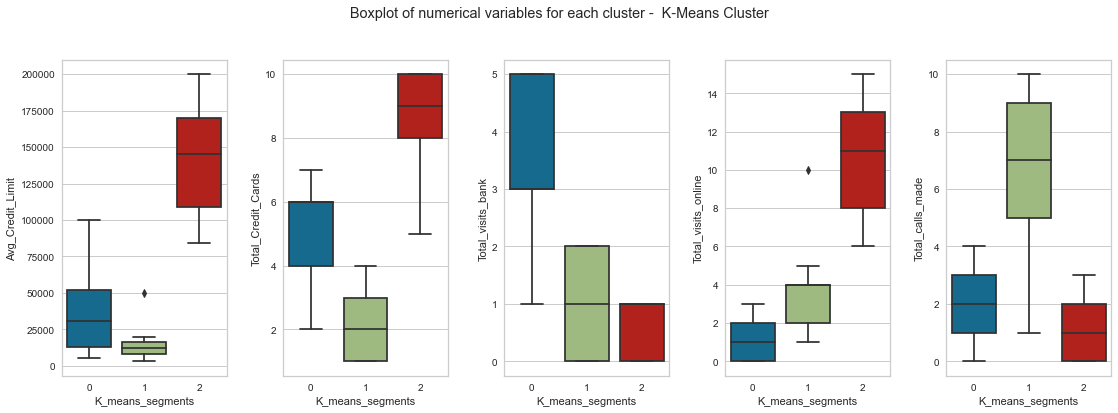

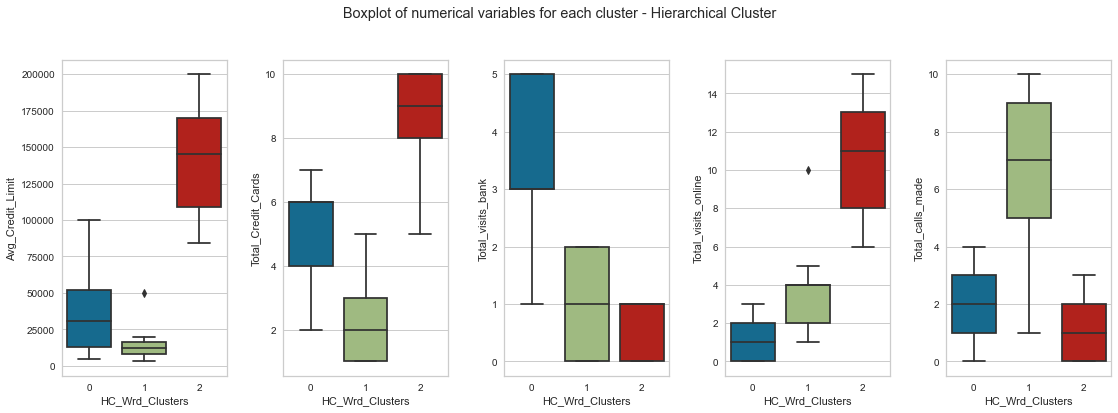

In [69]:
#Boxplot for K-Means Clustering Technique
fig, axes = plt.subplots(1, 5, figsize=(16, 6))

fig.suptitle("Boxplot of numerical variables for each cluster -  K-Means Cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df_k3[num_col[counter]], x=df_k3["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

#Boxplot for Hierarchical Clustering Technique
fig, axes = plt.subplots(1, 5, figsize=(16, 6))

fig.suptitle("Boxplot of numerical variables for each cluster - Hierarchical Cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df_HC_Wrd[num_col[counter]], x=df_HC_Wrd["HC_Wrd_Clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

We can agree that the boxplots look quite similar and almost indistinguishable even though they are from two different methods. We can conclude that both techniques have yielded quite comparable clusters.

Let's now infer some insights from the different clusters. We'll use the clusters from K-Means technique. Suffice it to say that similar insights will be made if we use the clusters from Hierarchical technique.

The insights below will be in descending order of the total number of customers in each cluster.

## Insights about different clusters. 

- **Cluster 0**
   - This cluster has the highest number of customers; a total of 386 out of 660 customers, which is about 58% of all customers. 
   - The average credit limit is moderately low with an average of about \\$34,000 but ranges mostly from about \\$12,500 to about \\$50,000.
   - Total credit cards is moderately okay between 4 to 6 credit cards.
   - Customers in this cluster visits the bank the most, having about 3 to 5 bank visits.
   - This cluster has the lowest total online visits which is between 0 and 2 visits. This is not surprising as they have the highest total bank visits. They prefer physical interaction to online interaction with the bank
   - This cluster has a moderately low total calls made which is between 1 and 3 calls.
   - Safe to say, they prefer to visit the bank rather than use online and phone banking and are therefore potential converts to online banking.
   - An easy way for these customers to perceive poor support services is delays in resolving their issues when they come to the bank (long queues), etc.



- **Cluster 1**
   - There are 224 customers in this cluster.
   - This cluster has the lowest average credit limit which averages about \\$12,000, making them potentials for increase in credit limit to encourage more spending.
   - This cluster also has the lowest number of total credit cards with an average of just 2, making them potentials for more credit cards.
   - Total visits to the bank is also quite low, average is 1 but ranges between 0 and 2 visits.
   - This cluster has a moderate total visits online which ranges between 2 to 4 visits.
   - Total calls made is the highest in this cluster, having as much as between 5 to 9 calls.
   - An easy way for these customers to perceive poor support services is delays in taking their calls to quickly resolve issues or answer their enquiries. 
   
   
- **Cluster 2**
   - There are only 50 customers in this cluster which has the lowest number of customers.
   - This cluster boasts of the highest credit limit ranging mostly from above \\$100,000 up to about \\$175,000. Average being \\$141,000.
   - This cluster also has the highest number of total credit cards ranging from between 8 to 10 credit cards.
   - Customers here rarely visit the bank thereby having the lowest bank visit of between 0 and 1.
   - This cluster has the most online visits of the three clusters, having between 8 to 13 visits
   - Total calls made is the lowest in this cluster, having as low as between 0 to 2 calls.
   - These are the premium high net worth customers. 
   - An easy way for these customers to perceive poor support services is bank website downtimes. Another way is poorly developed bank website that makes it difficult for customers to navigate and quickly find what they need.

# Business Recommendations

The following is recommended for each of the clusters recognized.

- **Cluster 0**: 
    - Customers in this group should be encouraged to embrace online banking since they have the lowest online visits. While at it, it is important to maintain quality face-to-face customer service at the bank in order to keep the customers in this group since they constitute 58% of all customers. Flyers, handbills and other legible posters should be strategically placed within the banking halls to catch their attention to new products, services and ease of online banking.


- **Cluster 1**: 
    - Customers in this group should be the target for increase in credit card limit and also increase in number of credit cards (which is low; only 2). These will enable them spend more, making revenue for AllLife Bank. They make the most calls; therefore should be target for great call center experience. Phone calls from this group can be utilized as marketing opportunities to present them with new bank products, features and services. Call centers must be adequately staffed to ensure quick turn around time in addressing issues and answering customer queries


- **Cluster 2**: 
    - The spending patterns of this group of high net worth customers should be studied. The aim will be to use email marketing to suggest great deals from online shops and vendors for their preffered products and services. This will encourage more spending and resulting revenue. Since they have the most online visits, any improvements to online banking should be done with this group in mind. Adequate online infrastructure that ensures optimal site uptime is very important. Downtimes to be avoided